# Measure and parameterize dropoff in $f_{features}$ for FERENGI-fied images in Galaxy Zoo: Hubble

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from astropy.table import Table
from scipy import optimize
from scipy.stats import distributions as dist
import numpy as np

In [2]:
# Load data

data = Table.read("../data/ferengi_sb.fits")

# Limit to galaxies that have data at z_sim = 0.3, since that's what we're normalizing to.
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < 0.301:
        z0ind[ind] = True
        
data_z0 = data[z0ind]
unique_galaxies_z0 = set(data_z0['sdss_id'])
print len(data_z0), len(unique_galaxies_z0)

3959 72


##### "Zeta method"

Assume that the change in $f_{features}$ as a function of redshift can be parameterized as:

$\frac{f_f}{f_{f,z=z_0}} = e^{-\frac{(z-z_0)}{\zeta}}$

where we set $z_0=0.3$, the lowest redshift in the FERENGIed images.

In [57]:
def fzeta_exp(p,x):
    
    #y = p[0] * np.exp(-1 * (x-p[1])/p[2])
    
    y = np.exp(-1 * (x-0.3)/p[0])

    return y
    
def fzeta_lin(p,x):
    
    y = 1 - (x-0.3) / p[0]

    return y

def fzeta(p,x):
    # results are qualitatively the same for both lin and exp versions
    return fzeta_exp(p,x)

def errfunc(p,x,y,s):
    
    err = (y - fzeta(p,x))/s

    return err

def common_labels(fig,xlabel=None,ylabel=None,xfontsize=12,yfontsize=12):

    # Set common labels
    cax = fig.add_subplot(111)    # The big subplot
    cax.set_axis_bgcolor('none')
    cax.spines['top'].set_color('none')
    cax.spines['bottom'].set_color('none')
    cax.spines['left'].set_color('none')
    cax.spines['right'].set_color('none')
    cax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    cax.set_xlabel(xlabel,fontsize=xfontsize)
    cax.set_ylabel(ylabel,fontsize=yfontsize)

    return cax

In [66]:
evols = np.unique(data_z0['sim_evolution'])
gals = [data_z0[np.absolute(data_z0['sim_evolution'] - evol) < 0.001] for evol in evols]

e0_z0 = gals[0][gals[0]['sim_redshift'] < 0.35]
#e0_z0.sort('mu_max_i')
#e0_z0.reverse()
e0_z0.sort('p_features')

In [87]:
def plot_trend(gal, ax):
    galaxy1 = g[ind]
    gal.sort('sim_redshift')
    
    z_gal = gal['sim_redshift']
    f_gal = gal['p_features']
    mu_gal = gal['mu_max_i'][0]
    
    #  ADD SOME ROUGH ERROR BARS
    c = 0.683
    n = 40  # assume 40 classifications per galaxy - better to use true value
    k = f_gal * n
    f_gal_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    f_gal_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    f_gal_err = (f_gal_upper - f_gal_lower) / 2.0
    f_gal_norm = f_gal / f_gal[0]
    f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm

    # Values must be explicitly cast as double-type precision for optimization to work. Incredibly frustrating.
    # Fix: http://stackoverflow.com/questions/12473406/scipy-optimize-leastsq-returns-best-guess-parameters-not-new-best-fit 

    p, cov, infodict, mesg, ier = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),
                                                                         f_gal_norm.astype(np.float64),
                                                                         f_gal_norm_err.astype(np.float64)),
                                                   full_output=1)
    ax.plot(z_gal,f_gal_norm,lw=2)
    ax.errorbar(z_gal,f_gal_norm, f_gal_norm_err)
    zarr = np.linspace(0,1,50)
    ax.plot(zarr,fzeta(p,zarr),'--',lw=1)
    ax.set_title('$f: {:.1f}\; \mu: {:.1f}\; \zeta: {:.1f}$'.format(f_gal[0], mu_gal, p[0]))
    ax.set_xlim(0,0.999)
    ax.set_ylim(0,1.999)   

/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


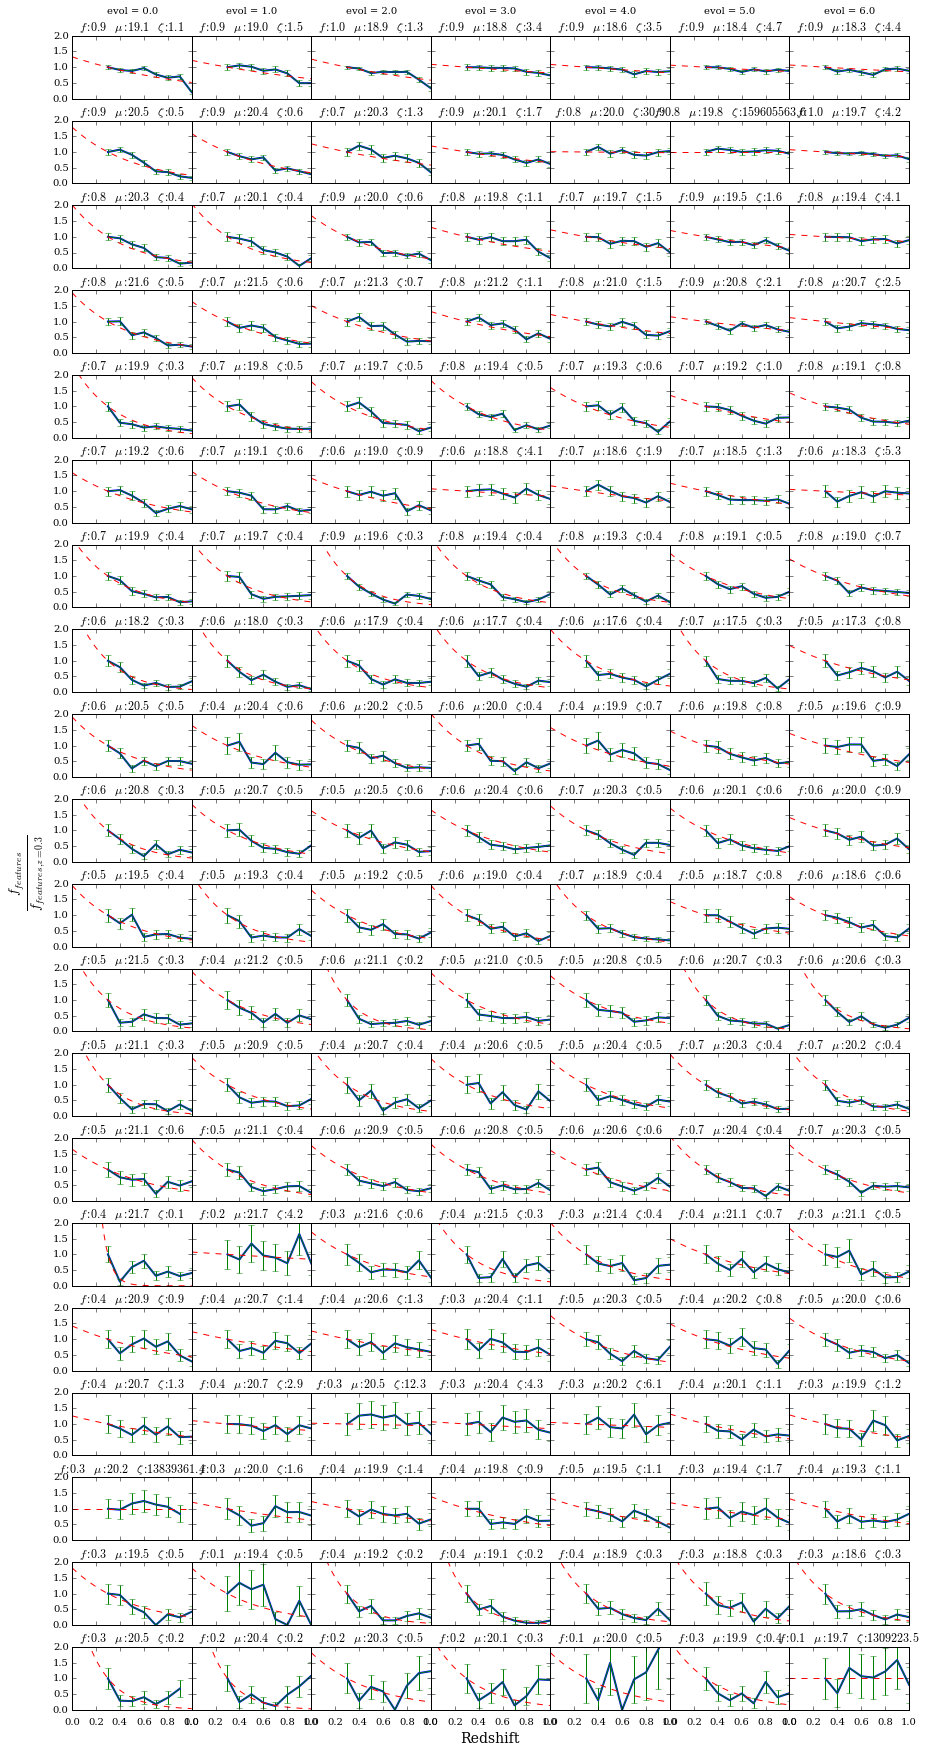

In [88]:
unique_galaxies = e0_z0['sdss_id'].tolist()
p_guess = np.array([0.5])

# Set up plot
fig,axarr = plt.subplots(nrows=20,ncols=len(evols),sharex=True,sharey=True,figsize=(15,30))
bigax = common_labels(fig,'Redshift',r'$\frac{f_{features}}{f_{features,z=0.3}}$',14,20)

for gal_i, gal_ax in enumerate(axarr):
    slen = 0
    while slen < (len(p_guess)+1):
        gal_id = unique_galaxies.pop()
        ind = (gals[0]['sdss_id'] == unique_galaxies.pop())
        slen = sum(ind)
    for evol_i, evol_ax in enumerate(gal_ax):
        if gal_i == 0:
            evol_ax.text(0.5,2.7,'evol = {:.1f}'.format(evol_i),
                        horizontalalignment='center')
        g = gals[evol_i]
        ind = g['sdss_id'] == gal_id
        plot_trend(g[ind], evol_ax)
    
fig.subplots_adjust(hspace=0.35, wspace=0)

In [89]:
# Find zeta for all images

data_z0['zeta'] = np.ones(len(data_z0)) * -99
data_z0['delchisq'] = np.ones(len(data_z0)) * -99

for gal in unique_galaxies:
    
    # Loop over evolution corrections
    
    for evo in set(data_z0['sim_evolution']):
        
        # Find data for this galaxy at all redshifts
        
        ind = (data_z0['sdss_id'] == gal) & (np.absolute(data_z0['sim_evolution'] - evo) < 0.001)
        
        # Make sure there are enough points to fit a function
        if sum(ind) > 3:
        
            galaxy1 = data_z0[ind]
            
            z_gal = galaxy1['sim_redshift']
            f_gal = galaxy1['p_features']
            #  ADD SOME ROUGH ERROR BARS
            c = 0.683
            n = 40  # assume 40 classifications per galaxy - better to use true value
            k = f_gal * n
            f_gal_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
            f_gal_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
            f_gal_err = (f_gal_upper - f_gal_lower) / 2.0
            f_gal_norm = f_gal / f_gal[0]
            f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm
            
            try:
                p, cov = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),
                                                                f_gal_norm.astype(np.float64),
                                                                f_gal_norm_err.astype(np.float64)))
                zeta = p[0]
                chisq = (((f_gal_norm - fzeta(p,z_gal)) / f_gal_norm_err)**2).sum()
                chisq_const = (((f_gal_norm - f_gal_norm.mean()) / f_gal_norm_err)**2).sum()
                delchisq = chisq_const - chisq
            except TypeError:
                print 'Galaxy %s has only %i redshifted images' % (galaxy1['sdss_id'][0],len(z_gal))
                zeta = -99.
                
            # Add zeta values to the larger table
            data_z0['zeta'][ind] = p[0]
            data_z0['delchisq'][ind] = delchisq

/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: invalid value encountered in multiply


/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


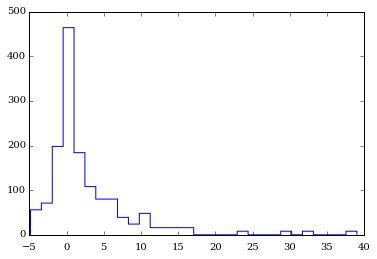

In [90]:
_ = plt.hist(data_z0['delchisq'][data_z0['delchisq']>-5], 30, histtype='step')

In [91]:
# How many galaxies have well-measured zeta values?

print '%i galaxies have well-measured zeta values' % ((data_z0['zeta'] < 10.) & (data_z0['zeta'] > -99.)).sum()
print '%i galaxies have zeta = -99' % (data_z0['zeta'] < -98.).sum()
print len(data_z0['zeta'])

1372 galaxies have well-measured zeta values
2217 galaxies have zeta = -99
3959


50 (19 unique) galaxies with measured zeta values.



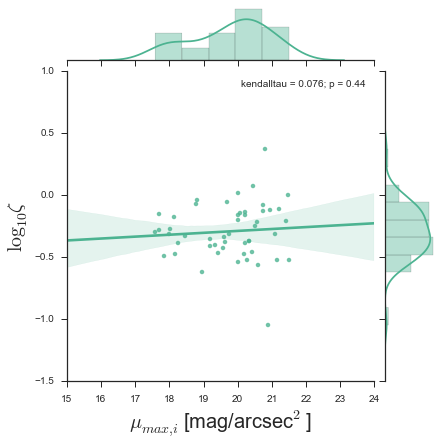

In [92]:
# Plot distribution of zeta as function of surface brightness
from scipy.stats import kendalltau
import seaborn as sns

sns.set(style="ticks")

# Only select unique galaxies (zeta is the same for all redshifts)
dz3 = data_z0[(data_z0['sim_redshift'] == 0.3) & (data_z0['p_features'] >= 0.0) & (data_z0['delchisq'] > 3.0)]

# Limit zeta to "sensible" values
zetalim = dz3[(dz3['zeta'] < 10.) & (dz3['zeta'] > -98.)]
x = zetalim['mu_max_i']
y = np.log10(zetalim['zeta'])
print "%i (%i unique) galaxies with measured zeta values.\n" % (len(zetalim),len(set(zetalim['sdss_id'])))

jg = sns.jointplot(x, y, kind="reg", stat_func=kendalltau, color="#4CB391")
jg.set_axis_labels(r'$\mu_{max,i}$ [mag/arcsec$^2$]',r'$\log_{10}{\zeta}$',fontsize=20)

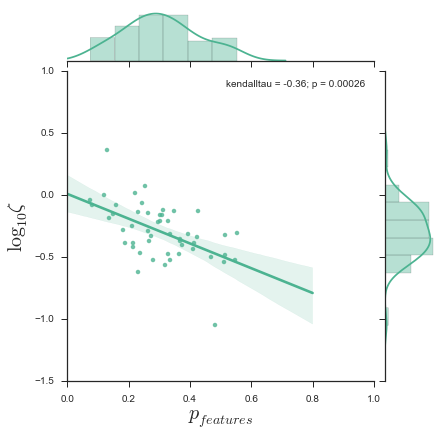

In [93]:
# Plot distribution of zeta as function of p_features
x = zetalim['p_features']
y = np.log10(zetalim['zeta'])

jg = sns.jointplot(x, y, kind="reg", stat_func=kendalltau, color="#4CB391")
jg.set_axis_labels(r'$p_{features}$',r'$\log_{10}{\zeta}$',fontsize=20)
_ = plt.axis(xmin=0, xmax=1)

# correlation vs SB seems to be driven by p_fraction(z0)

In [255]:
print 'Seems like zeta = {:.1f} is a reasonable first order correction'.format(10**y.mean())

Seems like zeta = 0.6 is a reasonable first order correction
